In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib notebook
from time import time

import tensorflow as tf
from tensorflow import keras

from useful_functions import load_transform_split, color_scatter, scatter_predvreal, get_metric, plot_performance, ann_fit
from RandomSeedSearchCV import RandomSeedSearchCV, randomseed_ann_maker

from joblib import dump,load

In [2]:
X_train,X_test,y_train,y_test,w_train,w_test,pipeline = load_transform_split(target='DROPOUT_N',
                                                              weight='COHORT_CNT',
                                                              expand=False,
                                                              clean=True,
                                                              split=0.2,
                                                              return_pipeline=True,
                                                              fmt='numpy',
                                                              random_state=42)

wmax = np.max([np.max(w_train),np.max(w_test)])
w_train = (w_train+100)/(wmax+100)
print(np.min(w_train),np.max(w_train))
w_test = (w_test+100)/(wmax+100)
print(np.min(w_test),np.max(w_test))

0.2927536231884058 0.9768115942028985
0.2927536231884058 1.0


[[ 75.           2.10406457   1.83682428 171.42359519]
 [ 54.           2.09035317   1.8578113   83.32283735]
 [ 47.           2.30917531   2.04899567 117.95273232]
 [ 35.           2.40760784   2.13128055 128.7075119 ]
 [ 79.           4.7375567    4.34890663  11.08712864]
 [111.           5.60283292   5.14706903  12.53691626]
 [ 48.           5.60283292   5.14706903  12.01520085]
 [ 53.           5.60283292   5.14706903  10.28818583]
 [ 22.           5.60283292   5.14706903  14.83864403]
 [  4.           5.60283292   5.14706903  11.13432145]
 [ 78.           5.60283292   5.14706903  12.04015255]
 [ 85.           5.60283292   5.14706903  14.52506423]]


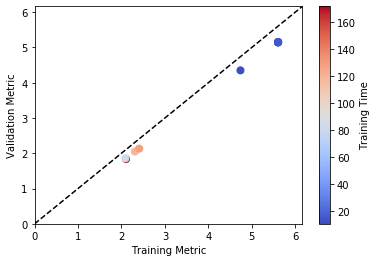

In [3]:
#CAUTION: This cell takes awhile unless you make N small.

optimizer = keras.optimizers.Adam()
#Searching through neural net models.
tbl = RandomSeedSearchCV(randomseed_ann_maker,X_train,y_train,w_train=w_train,N=12,cv=1,
                         input_shape=[X_train.shape[1]],
                         output_shape=1,output_activation='relu',
                         loss='mean_squared_error',optimizer=optimizer,
                         custom_fit = ann_fit,cone=True,
                         fit_params={'epochs':15,'bail_init_loss':1.9,'verbose':False})
print(tbl)

#Get best model.
best_seed = int(tbl[0,0])
best_model = randomseed_ann_maker(best_seed,input_shape=[X_train.shape[1]],
                                  output_shape=1,output_activation='relu',
                                  loss='mean_squared_error',optimizer=optimizer)

In [6]:
best_model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_143 (Dense)            (None, 18)                360       
_________________________________________________________________
dense_144 (Dense)            (None, 16)                304       
_________________________________________________________________
dense_145 (Dense)            (None, 16)                272       
_________________________________________________________________
dense_146 (Dense)            (None, 15)                255       
_________________________________________________________________
dense_147 (Dense)            (None, 14)                224       
_________________________________________________________________
dense_148 (Dense)            (None, 11)                165       
_________________________________________________________________
dense_149 (Dense)            (None, 11)              

In [4]:
best_model = randomseed_ann_maker(best_seed,input_shape=[X_train.shape[1]],
                                  output_shape=1,output_activation='relu',cone=True,
                                  loss='mean_squared_error',optimizer=optimizer)
best_model.fit(X_train,y_train,epochs=15,sample_weight=w_train)

Train on 57656 samples
Epoch 1/15
57656/57656 [==============================] - 23s 401us/sample - loss: 2.0463
Epoch 2/15
57656/57656 [==============================] - 16s 280us/sample - loss: 1.7561
Epoch 3/15
57656/57656 [==============================] - 18s 308us/sample - loss: 1.5868
Epoch 4/15
57656/57656 [==============================] - 17s 301us/sample - loss: 1.3521
Epoch 5/15
57656/57656 [==============================] - 18s 305us/sample - loss: 1.1890
Epoch 6/15
57656/57656 [==============================] - 17s 303us/sample - loss: 1.1249
Epoch 7/15
57656/57656 [==============================] - 17s 289us/sample - loss: 1.1022
Epoch 8/15
57656/57656 [==============================] - 17s 295us/sample - loss: 1.0693
Epoch 9/15
57656/57656 [==============================] - 17s 287us/sample - loss: 1.0303
Epoch 10/15
57656/57656 [==============================] - 17s 303us/sample - loss: 1.0051
Epoch 11/15
57656/57656 [==============================] - 17s 290us/sample 

In [10]:
mse = get_metric('mean_squared_error')

print("Best RFR: Train RMSE = %.2f, Test RMSE = %.2f"%(
                               np.sqrt(mse(best_model,X_train,y_train)),
                               np.sqrt(mse(best_model,X_test,y_test)),
                               ))

Best RFR: Train RMSE = 1.38, Test RMSE = 1.44


In [11]:
#Store random search output and pickle best model.
np.savetxt("trial1_ANN_randomseedsearch.out",tbl,header='seed  training_mse  validation_mse  training_time(s)')
best_model.save('saved_models/trial1_best_ann_DROPOUT_N.h5') 

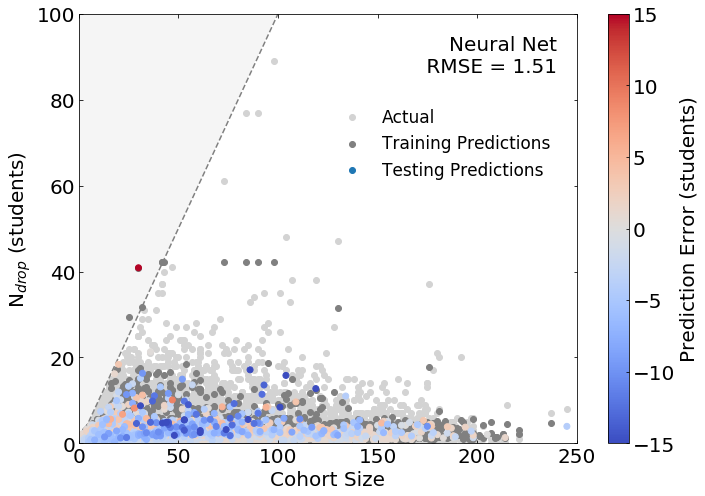

In [5]:
#Make a pretty plot
plt.rcParams.update({
                     'xtick.direction':'in',
                     'xtick.top':True,
                     'xtick.bottom':True,
                     'ytick.direction':'in',
                     'ytick.right':True,
                     'ytick.left':True,
})

#rfr = load('saved_models/best_RandomForestRegressor_DROPOUT_N.joblib')
ann = best_model
ax = plot_performance(ann,'Neural Net',X_train,X_test,y_train,y_test)

plt.tight_layout()
#ax.figure.savefig('figures/trial2_best_ann_summary.png',dpi=450)

In [14]:
best_model = randomseed_ann_maker(5,input_shape=[X_train.shape[1]],
                                  output_shape=1,output_activation='relu',
                                  loss='mean_squared_error',optimizer=optimizer)
history = best_model.fit(X_train,y_train,epochs=1)
best_model.summary()

Train on 57656 samples
57656/57656 [==============================] - 25s 440us/sample - loss: 3.2937
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 6)                 120       
_________________________________________________________________
dense_25 (Dense)             (None, 18)                126       
_________________________________________________________________
dense_26 (Dense)             (None, 14)                266       
_________________________________________________________________
dense_27 (Dense)             (None, 9)                 135       
_________________________________________________________________
dense_28 (Dense)             (None, 15)                150       
_________________________________________________________________
dense_29 (Dense)             (None, 11)                176       
__________________

In [22]:
history = best_model.fit(X_train,y_train,epochs=1)

Train on 57656 samples
57656/57656 [==============================] - 17s 291us/sample - loss: 2.6203


In [21]:
history.history['loss']

[2.8101285882030558]

In [13]:
best_model.predict(X_test[:1,:])

array([[-0.]], dtype=float32)

In [7]:
reinit_ann(best_model)

AttributeError: module 'tensorflow' has no attribute 'variables_initializer'

In [12]:
best_model.reset_states()

In [17]:
best_model = randomseed_ann_maker(8,input_shape=[X_train.shape[1]],
                                  output_shape=1,output_activation='relu',
                                  loss='mean_squared_error',optimizer=optimizer,cone=True)
best_model.summary()

START: 2
LAYER 20 0
18 2 9
20 11
LAYER 11 1
9 1 9
11 2
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_110 (Dense)            (None, 11)                220       
_________________________________________________________________
dense_111 (Dense)            (None, 3)                 36        
_________________________________________________________________
dense_112 (Dense)            (None, 1)                 4         
Total params: 260
Trainable params: 260
Non-trainable params: 0
_________________________________________________________________
